<a href="https://colab.research.google.com/github/henriquepaes1/churn/blob/main/Projeto_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction fazer a pesquisa e introdução

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [ ]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)
# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.shape

(7043, 21)

## Explorando o dataset 
Antes de começarmos as análises, é importante entender como nosso dataset está disposto, seus tipos e afins.

### Tipos das variáveis

In [ ]:
# Verificar o tipo de dado salvo em cada coluna
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
# Lidar com valores ausentes
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Algumas considerações importantes sobre as variáveis das colunas:

* A coluna tenure indica há quantos meses o cliente assina o serviço
* A coluna TotalCharges tem entrada igual a um espaço em branco quando o cliente ainda não completou seu primeiro mês de uso. Portanto, é necessário mudar essas entradas para 0.

## Entendendo o problema
Dada a introdução prévia a respeito do problema, vamos começar os estudos para entender como extrair as melhores informações do conjunto de dados. Nesse estudo, vamos considerar que quanto mais serviços um cliente contrata, maior a "fidelidade", consequentemente, menos chance desse cliente deixar de contratar os serviços da empresa. Assim, é possível definir uma espécie de "hierarquia", quando levando em consideração os serviços assinados por um dado cliente.

## Removendo colunas irrelevantes para a análise
Existem algumas colunas que não dizem respeito ao uso dos serviços fornecidos pela empresa, que não são relevantes para a previsão de evasão de cliente proposta nesse trabalho.

In [ ]:
df.drop(['customerID', 'gender', 'PaperlessBilling', 'PaymentMethod', 'Dependents', 'SeniorCitizen'], axis=1, inplace=True)

Para análise mais imediata, desconsiderando os descontos oferecidos por tempo de assinatura (que podem ser notados ao multiplicar o número de meses de assinatura pelo valor mensal pago), é válido excluir a coluna "TotalCharges", que indicam quanto o cliente gastou em todo o tempo de contrato, a fim de entender como o valor da parcela influencia no cancelamento do cliente.

In [ ]:
df.drop('TotalCharges', axis=1, inplace=True)


## Lidando com as variáveis categóricas
No nosso dataset, foi possível observar muitas variáveis do tipo object, que prejudicam o modelo matematicamente. Por isso, é necessário fazer algumas alterações nos dados.

Inicialmente, modificaremos as colunas *churn* (1 se a empresa perdeu o cliente, 0 se não) e *tenure* (quantos meses o cliente possui vínculo com a empresa), transformando-as para um tipo numérico. 

In [ ]:
df.Churn.replace({"Yes": '1', "No": '0'}, inplace=True)
df.Churn = pd.to_numeric(df.Churn) # houve churn

# Alterar o tipo das colunas para numérico quando aplicável
df.tenure = pd.to_numeric(df.tenure) # meses de assinatura

Nesse momento, nosso dataset ainda conta com muitas variáveis categóricas. Para lidarmos com elas corretamente, sem comprometer nossa análise matematicamente (adicionar "pesos" desnecessários a algumas variáveis), vamos utilizar a técnica de OneHotEncoding, que separará as respostas possíveis para os campos em colunas, com valores 1 ou 0, indicando se o cliente contrata ou não determinado serviço.


In [ ]:
df = pd.get_dummies(df)


In [ ]:
df.dtypes

tenure                                    int64
MonthlyCharges                          float64
Churn                                     int64
Partner_No                                uint8
Partner_Yes                               uint8
PhoneService_No                           uint8
PhoneService_Yes                          uint8
MultipleLines_No                          uint8
MultipleLines_No phone service            uint8
MultipleLines_Yes                         uint8
InternetService_DSL                       uint8
InternetService_Fiber optic               uint8
InternetService_No                        uint8
OnlineSecurity_No                         uint8
OnlineSecurity_No internet service        uint8
OnlineSecurity_Yes                        uint8
OnlineBackup_No                           uint8
OnlineBackup_No internet service          uint8
OnlineBackup_Yes                          uint8
DeviceProtection_No                       uint8
DeviceProtection_No internet service    

In [ ]:
df.head()

,tenure,MonthlyCharges,Churn,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
0,1,29.85,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
1,34,56.95,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0
2,2,53.85,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,45,42.30,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0
4,2,70.70,1,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0


Agora que todas as variáveis são numéricas, é possível dar o próximo passo na análise.

## Normalizando as variáveis
Mesmo com todas as variáveis categóricas sendo devidamente trabalhadas, algumas colunas ainda podem enviezar nosso estudo por diversos motivos. No nosso caso, as colunas "tenure" e "MonthlyCharge" possuem valores muito maiores que os zeros e uns do resto do dataset, isso por que possuem uma escala própria (meses e dólares, respectivamente), isso exige uma *normalização*. Por termos usado o método de OneHotEncoder, queremos que as colunas *tenure* e *MonthlyCharge* também tenham valores entre 0 e 1, para isso, utilizaremos o MinMaxScaler.

In [ ]:
X = df.drop('Churn', axis=1)
y = df.Churn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = MinMaxScaler()

In [ ]:
df_train = X_train.copy()
df_test = X_test.copy()

df_train['MonthlyCharges'] = scaler.fit_transform(np.array(df_train['MonthlyCharges']).reshape(-1, 1))
df_train.tenure = scaler.fit_transform(np.array(df_train.tenure).reshape(-1, 1))
df_test['MonthlyCharges'] = scaler.fit_transform(np.array(df_test['MonthlyCharges']).reshape(-1, 1))
df_test.tenure = scaler.fit_transform(np.array(df_test.tenure).reshape(-1, 1))

## Balanceamento dos dados

In [ ]:
df.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

Aqui, pode-se perceber que trata-se de um dataset desbalanceado e que, algumas entradas devem ser removidas para que o modelo funcione melhor. Vamos balancear os dados removendo entradas da classe majoritária.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
rus = RandomUnderSampler()
X_treino, y_treino = rus.fit_resample(df_train, y_train)

In [ ]:
y_treino.value_counts()

1    1408
0    1408
Name: Churn, dtype: int64

Agora, com os datasets prontos, podemos começar a criar os modelos.

In [ ]:
X_treino.head()

,tenure,MonthlyCharges,Partner_No,Partner_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
0,0.027778,0.015446,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
1,0.430556,0.856502,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0
2,0.444444,0.826607,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0
3,0.027778,0.281016,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4,0.236111,0.012955,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0


## Criando os modelos 


Por tratar-se de um problema de classificação, criaremos 2 modelos: um utilizando Regressão Logística e outro utilizando o método dos K-ésimos vizinhos mais próximos.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
log = LogisticRegression()
kneig = KNeighborsClassifier()

log.fit(X_treino, y_treino)
kneig.fit(X_treino, y_treino)

# Criando os modelos e definindo parâmetros para o nosso dataset

KNeighborsClassifier()

In [ ]:
pred_log = log.predict(X_test)
pred_knn = kneig.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_log))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1300
           1       0.53      0.50      0.51       461

    accuracy                           0.75      1761
   macro avg       0.68      0.67      0.67      1761
weighted avg       0.75      0.75      0.75      1761



In [ ]:
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1300
           1       0.41      0.07      0.11       461

    accuracy                           0.73      1761
   macro avg       0.57      0.52      0.48      1761
weighted avg       0.66      0.73      0.65      1761



0    1300
1     461
Name: Churn, dtype: int64

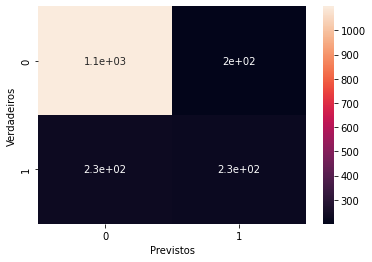

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_log), annot=True, ax=ax);
ax.set_xlabel("Previstos")
ax.set_ylabel("Verdadeiros");
y_test.value_counts()